# **Image segmentation on CARLA dataset**
### **Perform the segmentation on images using the U-Net architecture for autonomous car driving.**

**U-Net** *is a convolutional neural network architecture commonly used for image segmentation in medical images. Orginal paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) by Olaf Ronneberger, Philipp Fischer, Thomas Brox.*

**CARLA** *is an open source simulator for autonomous driving research [Link](https://carla.org/). The dataset used consists of 1000 images with their true masks for image segmentation.*

Please, if you use Colab, enable the GPU runtime.


In [104]:
import pickle as pkl
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

## Dataset:

### 1.1 Load the images
- Images are stored as separate Pickle files. 
- **The images are already resized from `800 x 600` to `128 x 96` dimensions.**
- You can use any dataset, for resizing please refer to `pack_images.py`

In [117]:
IMG_WIDTH = 128
IMG_HEIGHT = 96
NUM_CHANNELS = 3
NUM_CLASSES = 13

DATASET_IMAGES_DIR = 'dataset/dataset_images.pickle'
DATASET_MASKS_DIR = 'dataset/dataset_masks.pickle'

with open(DATASET_IMAGES_DIR, 'rb') as file:
    images = pkl.load(file)

with open(DATASET_MASKS_DIR, 'rb') as file:
    masks = pkl.load(file)

print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")

# calculate the number of classes +1 because 0 is none and we count neuron numbers.
# NUM_CLASSES = amax(masks) + 1


Images shape: (1000, 96, 128, 3), Masks shape: (1000, 96, 128)


### 1.2 Preview the images

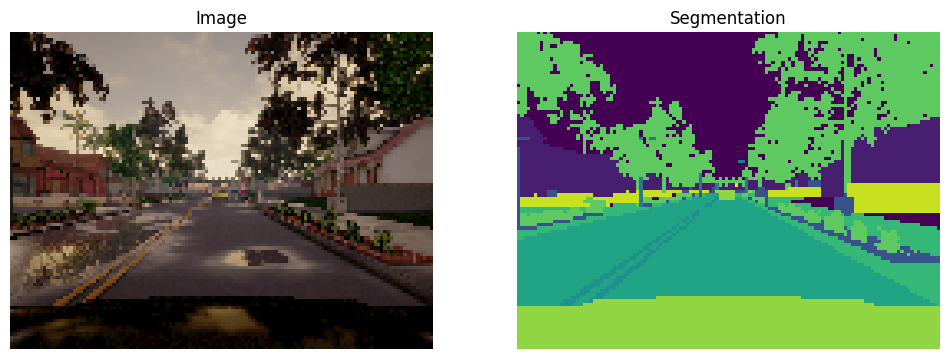

In [118]:
EXAMPLE_INDEX = 0

fig, arr = plt.subplots(1, 2, figsize=(12,12))

arr[0].imshow(images[EXAMPLE_INDEX])
arr[0].axis('off')
arr[0].set_title('Image')

arr[1].imshow(masks[EXAMPLE_INDEX])
arr[1].axis('off')
arr[1].set_title('Segmentation')

plt.show()

### 1.3 Create the dataset
- Images are normalized.
- Masks have an additional dimension to meet the network requirements.

In [119]:
images = (images / 255).astype(np.float32)
masks = np.expand_dims(masks, axis=-1)

dataset = tf.data.Dataset.from_tensor_slices((images, masks))


## U-Net Architecture
**U-Net architecture consists of three parts which on diagram looks like a letter "U":**
- **Downsampling block:** Reduce the image size but increase filter amount. It's also called encoder.
- **Bottelneck:**  Is between encoding and decoding part of network. It's the place where network learns on the most compressed representation of features. Sometimes it's not treated as a separate segment.
- **Upsampling block:** Gradually increase the size and reduce the filter amount back to image orginal size.

**It's important that each output of downsampling block is passed and concatenated to its corresponding upsampling block to preserve the details after each downsamplng step.**

### 2.1 Downsampling block

In [120]:
def downsampling_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = tf.keras.layers.Conv2D(n_filters,
                                  kernel_size=(3,3),
                                  activation='relu',
                                  padding='same',
                                  kernel_initializer= 'he_normal')(inputs)

    conv = tf.keras.layers.Conv2D(n_filters,
                                  kernel_size=(3,3),
                                  activation='relu',
                                  padding='same',
                                  kernel_initializer= 'he_normal')(conv)

    if dropout_prob > 0:
        conv =  tf.keras.layers.Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(2, strides=2)(conv)  
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### 2.2 Upsampling block

In [121]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = tf.keras.layers.Conv2DTranspose(n_filters,
                                         kernel_size=(3,3),
                                         strides=2,
                                         padding='same')(expansive_input)

    merge = tf.keras.layers.concatenate([up, contractive_input], axis=3)
    
    conv = tf.keras.layers.Conv2D(n_filters,
                                  kernel_size=(3,3), 
                                  activation='relu',
                                  padding='same',
                                  kernel_initializer= 'he_normal')(merge)

    conv = tf.keras.layers.Conv2D(n_filters,
                                  kernel_size=(3,3),  
                                  activation='relu',
                                  padding='same',
                                  kernel_initializer= 'he_normal')(conv)
    
    return conv

### 2.3 Model

In [122]:
def UNet(input_size=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), n_filters=32, n_classes=23):

    inputs = tf.keras.layers.Input(input_size)

    cblock1 = downsampling_block(inputs=inputs,     n_filters=n_filters * 1)
    cblock2 = downsampling_block(inputs=cblock1[0], n_filters=n_filters * 2)
    cblock3 = downsampling_block(inputs=cblock2[0], n_filters=n_filters * 4)
    cblock4 = downsampling_block(inputs=cblock3[0], n_filters=n_filters * 8,  dropout_prob=0.3)
    cblock5 = downsampling_block(inputs=cblock4[0], n_filters=n_filters * 16, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6,    cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7,    cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8,    cblock1[1], n_filters * 1)

    conv9 = tf.keras.layers.Conv2D(n_filters,
                                   kernel_size=(3,3),
                                   activation='relu',
                                   padding='same',
                                   kernel_initializer='he_normal')(ublock9)

    conv10 = tf.keras.layers.Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [123]:
model = UNet(input_size=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), n_classes=NUM_CLASSES)

# model.summary()

## Compile and train the model

### 3.1 Compile the model
We are using `SparseCategoricalCrossentropy` because image segmentation is a specific case of multiclass problem where instead of whole image we predict class per pixel.

In [124]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 3.2 Train the model
With 40 epochs you can reach above 97% accuracy.

In [125]:
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 32

dataset.batch(BATCH_SIZE)
train_dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

model_history = model.fit(train_dataset, epochs=EPOCHS)

Epoch 1/40
32/32 [==============================] - 12s 152ms/step - loss: 1.8504 - accuracy: 0.3564
Epoch 2/40
32/32 [==============================] - 5s 149ms/step - loss: 1.0341 - accuracy: 0.6677
Epoch 3/40
32/32 [==============================] - 5s 151ms/step - loss: 0.6061 - accuracy: 0.7956
Epoch 4/40
32/32 [==============================] - 5s 151ms/step - loss: 0.4829 - accuracy: 0.8507
Epoch 5/40
32/32 [==============================] - 5s 150ms/step - loss: 0.4464 - accuracy: 0.8626
Epoch 6/40
32/32 [==============================] - 5s 153ms/step - loss: 0.3947 - accuracy: 0.8768
Epoch 7/40
32/32 [==============================] - 5s 154ms/step - loss: 0.3392 - accuracy: 0.8941
Epoch 8/40
32/32 [==============================] - 5s 155ms/step - loss: 0.2956 - accuracy: 0.9076
Epoch 9/40
32/32 [==============================] - 5s 153ms/step - loss: 0.2614 - accuracy: 0.9179
Epoch 10/40
32/32 [==============================] - 5s 155ms/step - loss: 0.2393 - accuracy: 0.924

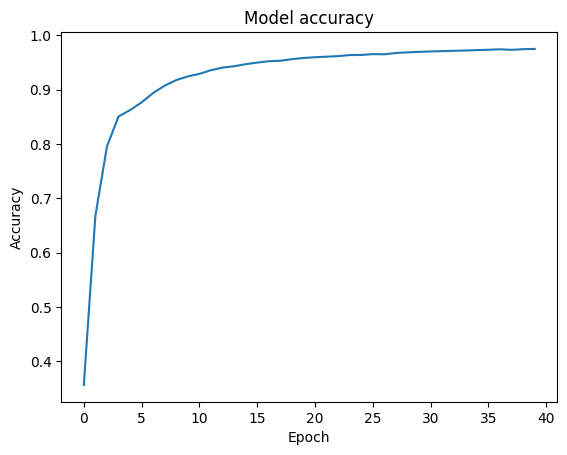

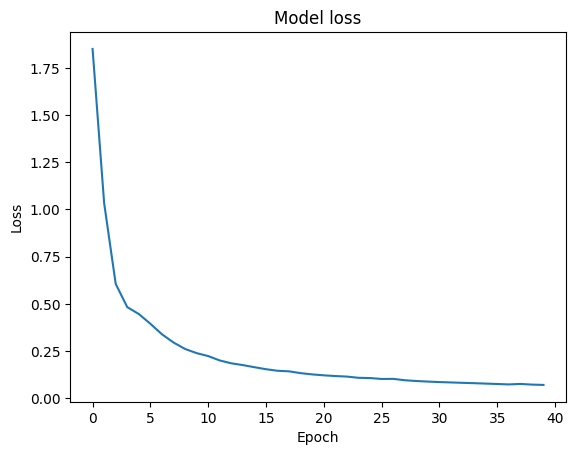

In [126]:
plt.plot(model_history.history["accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

plt.plot(model_history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

### 3.3 Predict and compare the results.
The code below takes first image from a specified amount of batches.

As you can see, the results are accurate but low-res images dropped many important features from images therefore there are some things missing. I could use full size images but I decided to have something quick to train.

The colors may be different between ground truth and prediction because some classes might be missing and pyplot assign different colors. Otherwise, it wouldn't be possible to reach 90% accuracy. *Todo: how to fix this?*


In [127]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def display_mask_comparison(image, true_mask, pred_mask):
    fig, arr = plt.subplots(1, 3, figsize=(15,15))

    arr[0].imshow(image)
    arr[0].axis('off')
    arr[0].set_title('Image')

    arr[1].imshow(true_mask)
    arr[1].axis('off')
    arr[1].set_title('True mask')

    arr[2].imshow(pred_mask)
    arr[2].axis('off')
    arr[2].set_title('Predicted mask')

    fig.show()


def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        pred_mask = create_mask(pred_mask)
        display_mask_comparison(image[0], mask[0], pred_mask)

1/1 [==============================] - 0s 22ms/step


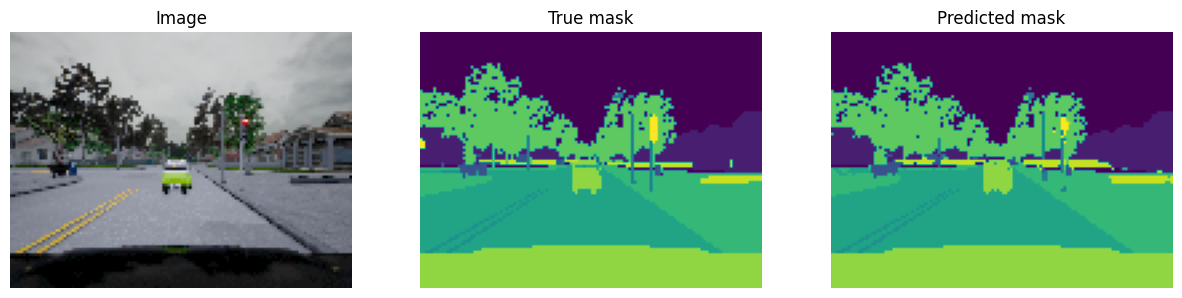

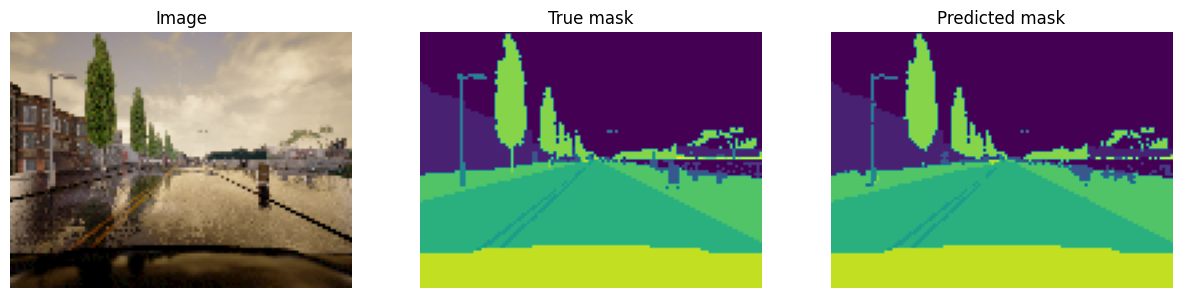

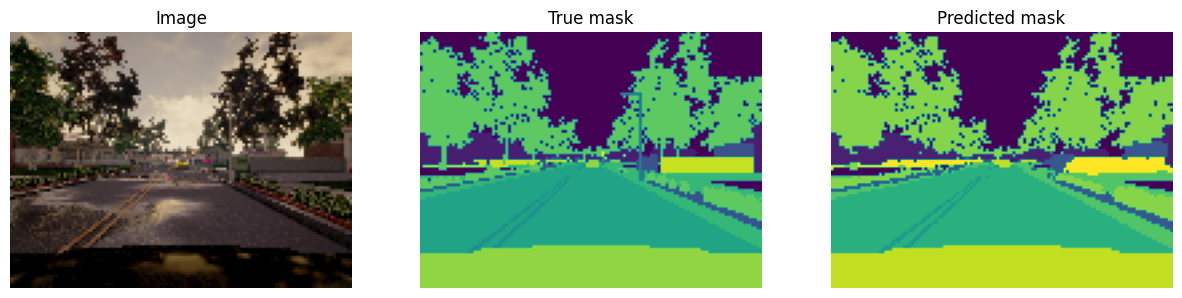

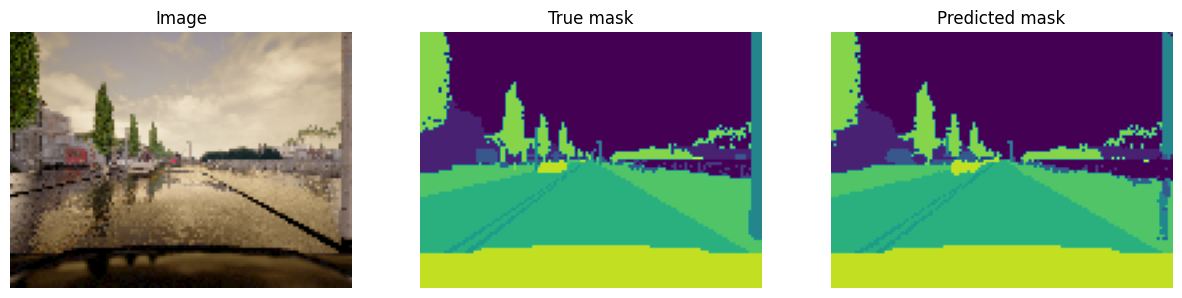

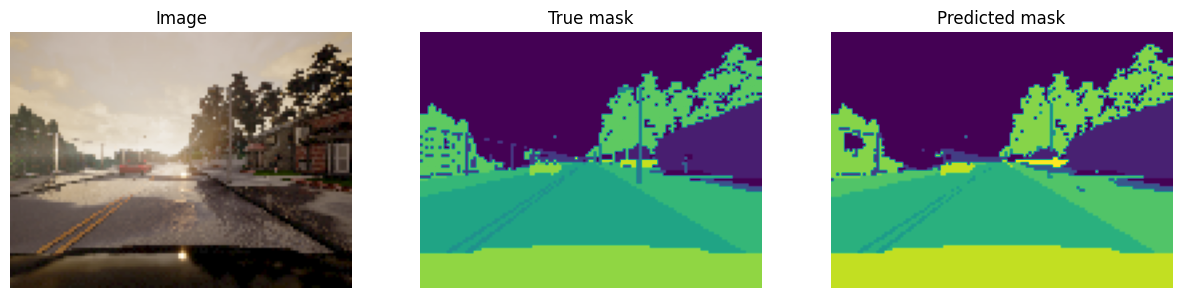

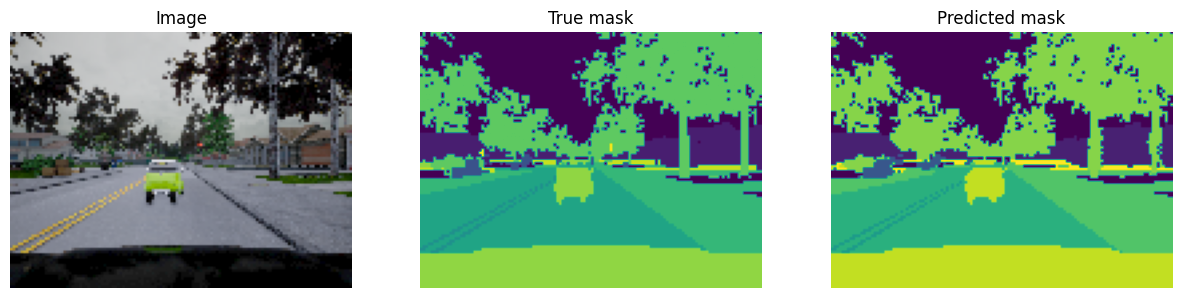

In [133]:
show_predictions(train_dataset, 6)